In [1]:
import sys
import os
import pickle
import time

import pandas as pd
import numpy as np
import humanize
import prettytable
from tqdm import tqdm

from matplotlib import pyplot as plt
from langdetect import detect, DetectorFactory
from concurrent.futures import ThreadPoolExecutor
from notebooks.helper import *

data_path = "../data/channel_messages"

In [150]:
all_files, all_data = os.listdir(data_path), []
total_bytes = sum(os.path.getsize(os.path.join(data_path, file)) for file in all_files)
print("Total size of files: ", humanize.naturalsize(total_bytes))

# use chunksize to read file in chunks, print progress
for i, file in enumerate(all_files):
    print(f"Reading file {i + 1} of {len(all_files)}", end="\r")
    with open(os.path.join(data_path, file), "rb") as f:
        all_data.append(pickle.load(f))
print(f"Read {len(all_data)} files")

total_messages = sum(len(data) for data in all_data)
print(f"Total messages: {total_messages}")

Total size of files:  631.2 MB
Read 8 files 8 of 8
Total messages: 335163


In [136]:
table = prettytable.PrettyTable(["Channel", "Messages"])
for channel in all_data:
    # print(channel.popitem()[1].chat.title)
    table.add_row([channel.popitem()[1].chat.title, len(channel)])
    
print(table)

+--------------------------------+----------+
|            Channel             | Messages |
+--------------------------------+----------+
|     Україна⚡️Новини⚡️Війна     |  47975   |
| Доброго вечора, ми з України👋 |  29336   |
|        Times of Ukraine        |  17890   |
|       НОВИНА 🇺🇦 Україна        |  59175   |
|             ҐРУНТ              |  34314   |
|           STERNENKO            |  17881   |
|      ТСН новини / ТСН.ua       |  92706   |
|          Ukraine NOW           |  35878   |
+--------------------------------+----------+


In [137]:
channels = ['Times of Ukraine', 'ҐРУНТ', 'STERNENKO', 'Ukraine NOW']

df_data = []
process_data = []
for channel in all_data:
    channel_name = channel.popitem()[1].chat.title
    
    if channel_name not in channels:
        continue
        
    process_data += channel.values()
    
messages = tqdm(process_data, total=len(process_data), desc=f"Processing data from {len(channels)} channels")
for i, message in enumerate(messages):
    if message.reactions is None:
        continue
    
    prepared_message = {
        "id": message.id,
        "source": message.chat.title,
        "date": message.date,
        "caption": message.caption,
        "text": message.text,
        "views": message.views,
        "forwards": message.forwards,
        "containing_media": message.media is not None,
    }
    
    for r in message.reactions.reactions:
        prepared_message[r.emoji] = r.count
        
    df_data.append(prepared_message)
        
df = pd.DataFrame(df_data)

Processing data from 4 channels: 100%|██████████| 105959/105959 [00:00<00:00, 127254.65it/s]


In [138]:
print(f"Shape of df: {df.shape}")
print(f"Size of df: {humanize.naturalsize(sys.getsizeof(df))}")
df.head(20)

Shape of df: (75469, 75)
Size of df: 120.2 MB


,id,source,date,caption,text,views,forwards,containing_media,👍,🤡,...,🎄,🎃,🎅,💘,🆒,💅,🤗,🤓,😘,😴
0,19189,Times of Ukraine,2023-07-24 13:20:42,🧡 Кадрові зміни у Кабміні. Новим керівником Мі...,None,84755,80,True,869.0,146.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19188,Times of Ukraine,2023-07-24 12:36:37,"💚 Не минуло і місяця після звільнення з ЗСУ, я...",None,104968,218,True,622.0,1684.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19187,Times of Ukraine,2023-07-24 11:41:15,У Польщі запрацював хаб з ремонту танків Leopa...,None,115646,77,True,2513.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19186,Times of Ukraine,2023-07-24 11:20:06,У Києві затримали колишнього віськкома-втікача...,None,120479,245,True,2639.0,127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19185,Times of Ukraine,2023-07-24 11:00:17,‼️ Через війну ціни в Києві виросли на 247%. \...,None,121536,324,True,154.0,144.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,19184,Times of Ukraine,2023-07-24 10:02:08,Джоні Деппа терміново шпиталізували у Будапешт...,None,132377,412,True,328.0,248.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,19183,Times of Ukraine,2023-07-24 09:17:19,Президент-втікач Віктор Янукович непогано живе...,None,148547,257,True,212.0,2798.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,19182,Times of Ukraine,2023-07-24 08:05:25,Потужна атака дронів на Крим — є влучання у ск...,None,157085,217,True,3081.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,19181,Times of Ukraine,2023-07-24 07:52:44,Ворог вночі атакував Одещину «шахедами» майже ...,None,155184,139,True,98.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,19180,Times of Ukraine,2023-07-24 07:43:21,"ЗСУ звільнили ~53% території, яку рф вдалось о...",None,152810,197,True,3085.0,133.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
# replace all None in caption and text with ""
df["caption"] = df["caption"].fillna("")
df["text"] = df["text"].fillna("")

# combine caption and text into one column
df["text"] = df["caption"] + " " + df["text"]
df = df.drop(["caption"], axis=1)

df.head(20)

,id,source,date,text,views,forwards,containing_media,👍,🤡,❤,...,🎄,🎃,🎅,💘,🆒,💅,🤗,🤓,😘,😴
0,19189,Times of Ukraine,2023-07-24 13:20:42,🧡 Кадрові зміни у Кабміні. Новим керівником Мі...,84755,80,True,869.0,146.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19188,Times of Ukraine,2023-07-24 12:36:37,"💚 Не минуло і місяця після звільнення з ЗСУ, я...",104968,218,True,622.0,1684.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19187,Times of Ukraine,2023-07-24 11:41:15,У Польщі запрацював хаб з ремонту танків Leopa...,115646,77,True,2513.0,18.0,361.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19186,Times of Ukraine,2023-07-24 11:20:06,У Києві затримали колишнього віськкома-втікача...,120479,245,True,2639.0,127.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19185,Times of Ukraine,2023-07-24 11:00:17,‼️ Через війну ціни в Києві виросли на 247%. \...,121536,324,True,154.0,144.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,19184,Times of Ukraine,2023-07-24 10:02:08,Джоні Деппа терміново шпиталізували у Будапешт...,132377,412,True,328.0,248.0,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,19183,Times of Ukraine,2023-07-24 09:17:19,Президент-втікач Віктор Янукович непогано живе...,148547,257,True,212.0,2798.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,19182,Times of Ukraine,2023-07-24 08:05:25,Потужна атака дронів на Крим — є влучання у ск...,157085,217,True,3081.0,11.0,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,19181,Times of Ukraine,2023-07-24 07:52:44,Ворог вночі атакував Одещину «шахедами» майже ...,155184,139,True,98.0,NaN,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,19180,Times of Ukraine,2023-07-24 07:43:21,"ЗСУ звільнили ~53% території, яку рф вдалось о...",152810,197,True,3085.0,133.0,770.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
# count reactions
reactions = df.drop(["id", "source", "date", "text", "views", "forwards", "containing_media"], axis=1)
reactions = pd.DataFrame(reactions.sum().sort_values(ascending=False))
reactions.columns = ["count"]
reactions["percentage"] = reactions["count"] / reactions["count"].sum() * 100
reactions

,count,percentage
❤,75151277.0,25.135656
👍,72532944.0,24.259909
🤬,44447371.0,14.866199
😁,43016626.0,14.387661
😢,33612854.0,11.242406
...,...,...
👨‍💻,72.0,0.000024
🙉,45.0,0.000015
🎅,27.0,0.000009
😴,25.0,0.000008


In [141]:
# drop reactions with less than 1% of total count in all channels
reactions = reactions[reactions["percentage"] < 5]
df = df.drop(reactions.index, axis=1)
df.head(20)

,id,source,date,text,views,forwards,containing_media,👍,❤,🤬,😢,😁
0,19189,Times of Ukraine,2023-07-24 13:20:42,🧡 Кадрові зміни у Кабміні. Новим керівником Мі...,84755,80,True,869.0,23.0,14.0,2.0,NaN
1,19188,Times of Ukraine,2023-07-24 12:36:37,"💚 Не минуло і місяця після звільнення з ЗСУ, я...",104968,218,True,622.0,80.0,277.0,21.0,NaN
2,19187,Times of Ukraine,2023-07-24 11:41:15,У Польщі запрацював хаб з ремонту танків Leopa...,115646,77,True,2513.0,361.0,10.0,NaN,NaN
3,19186,Times of Ukraine,2023-07-24 11:20:06,У Києві затримали колишнього віськкома-втікача...,120479,245,True,2639.0,23.0,8.0,4.0,NaN
4,19185,Times of Ukraine,2023-07-24 11:00:17,‼️ Через війну ціни в Києві виросли на 247%. \...,121536,324,True,154.0,23.0,854.0,74.0,NaN
5,19184,Times of Ukraine,2023-07-24 10:02:08,Джоні Деппа терміново шпиталізували у Будапешт...,132377,412,True,328.0,39.0,15.0,1120.0,NaN
6,19183,Times of Ukraine,2023-07-24 09:17:19,Президент-втікач Віктор Янукович непогано живе...,148547,257,True,212.0,23.0,1614.0,4.0,NaN
7,19182,Times of Ukraine,2023-07-24 08:05:25,Потужна атака дронів на Крим — є влучання у ск...,157085,217,True,3081.0,122.0,8.0,NaN,NaN
8,19181,Times of Ukraine,2023-07-24 07:52:44,Ворог вночі атакував Одещину «шахедами» майже ...,155184,139,True,98.0,32.0,2895.0,555.0,NaN
9,19180,Times of Ukraine,2023-07-24 07:43:21,"ЗСУ звільнили ~53% території, яку рф вдалось о...",152810,197,True,3085.0,770.0,9.0,50.0,NaN


In [2]:
# save df to csv
df_path = "../data/four_channels.csv"
# df.to_csv(df_path, index=False)

In [3]:
df = pd.read_csv(df_path)
df

,id,source,date,text,views,forwards,containing_media,👍,❤,🤬,😢,😁
0,19189,Times of Ukraine,2023-07-24 13:20:42,🧡 Кадрові зміни у Кабміні. Новим керівником Мі...,84755,80,True,869.0,23.0,14.0,2.0,NaN
1,19188,Times of Ukraine,2023-07-24 12:36:37,"💚 Не минуло і місяця після звільнення з ЗСУ, я...",104968,218,True,622.0,80.0,277.0,21.0,NaN
2,19187,Times of Ukraine,2023-07-24 11:41:15,У Польщі запрацював хаб з ремонту танків Leopa...,115646,77,True,2513.0,361.0,10.0,NaN,NaN
3,19186,Times of Ukraine,2023-07-24 11:20:06,У Києві затримали колишнього віськкома-втікача...,120479,245,True,2639.0,23.0,8.0,4.0,NaN
4,19185,Times of Ukraine,2023-07-24 11:00:17,‼️ Через війну ціни в Києві виросли на 247%. \...,121536,324,True,154.0,23.0,854.0,74.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
75464,8,Ukraine NOW,2020-03-08 11:10:01,Станом на ранок 8 березня в Україні зареєстро...,56846,105,False,NaN,1.0,NaN,NaN,1.0
75465,7,Ukraine NOW,2020-03-07 15:11:00,​​Міністерство охорони здоров’я України закли...,67616,214,True,NaN,5.0,NaN,NaN,1.0
75466,6,Ukraine NOW,2020-03-07 12:01:00,Міністерство охорони здоров’я України запусти...,62571,145,False,NaN,6.0,NaN,NaN,1.0
75467,5,Ukraine NOW,2020-03-07 11:12:13,Станом на ранок 7 березня 2020 року в Україні...,52026,113,False,1.0,3.0,NaN,NaN,2.0


<Axes: xlabel='source'>

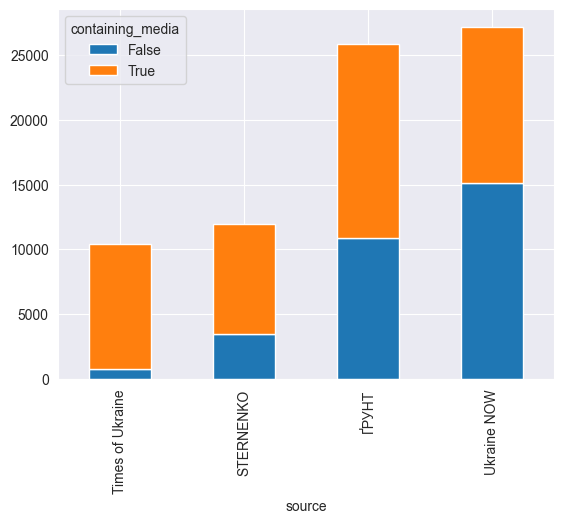

In [4]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

# count messages with and without media by source
df.groupby("source")["containing_media"].value_counts()
# plot it sorted count of messages without media
df.groupby("source")["containing_media"].value_counts().unstack().sort_values(by=False).plot(kind="bar", stacked=True)

In [5]:
df["time"] = df["date"].apply(lambda x: x.split(" ")[1])
df["date"] = df["date"].apply(lambda x: x.split(" ")[0])
new_columns = df.columns.tolist()[:-1]
new_columns.insert(3, "time")
df = df[new_columns]
df.head(20)

,id,source,date,time,text,views,forwards,containing_media,👍,❤,🤬,😢,😁
0,19189,Times of Ukraine,2023-07-24,13:20:42,🧡 Кадрові зміни у Кабміні. Новим керівником Мі...,84755,80,True,869.0,23.0,14.0,2.0,NaN
1,19188,Times of Ukraine,2023-07-24,12:36:37,"💚 Не минуло і місяця після звільнення з ЗСУ, я...",104968,218,True,622.0,80.0,277.0,21.0,NaN
2,19187,Times of Ukraine,2023-07-24,11:41:15,У Польщі запрацював хаб з ремонту танків Leopa...,115646,77,True,2513.0,361.0,10.0,NaN,NaN
3,19186,Times of Ukraine,2023-07-24,11:20:06,У Києві затримали колишнього віськкома-втікача...,120479,245,True,2639.0,23.0,8.0,4.0,NaN
4,19185,Times of Ukraine,2023-07-24,11:00:17,‼️ Через війну ціни в Києві виросли на 247%. \...,121536,324,True,154.0,23.0,854.0,74.0,NaN
5,19184,Times of Ukraine,2023-07-24,10:02:08,Джоні Деппа терміново шпиталізували у Будапешт...,132377,412,True,328.0,39.0,15.0,1120.0,NaN
6,19183,Times of Ukraine,2023-07-24,09:17:19,Президент-втікач Віктор Янукович непогано живе...,148547,257,True,212.0,23.0,1614.0,4.0,NaN
7,19182,Times of Ukraine,2023-07-24,08:05:25,Потужна атака дронів на Крим — є влучання у ск...,157085,217,True,3081.0,122.0,8.0,NaN,NaN
8,19181,Times of Ukraine,2023-07-24,07:52:44,Ворог вночі атакував Одещину «шахедами» майже ...,155184,139,True,98.0,32.0,2895.0,555.0,NaN
9,19180,Times of Ukraine,2023-07-24,07:43:21,"ЗСУ звільнили ~53% території, яку рф вдалось о...",152810,197,True,3085.0,770.0,9.0,50.0,NaN


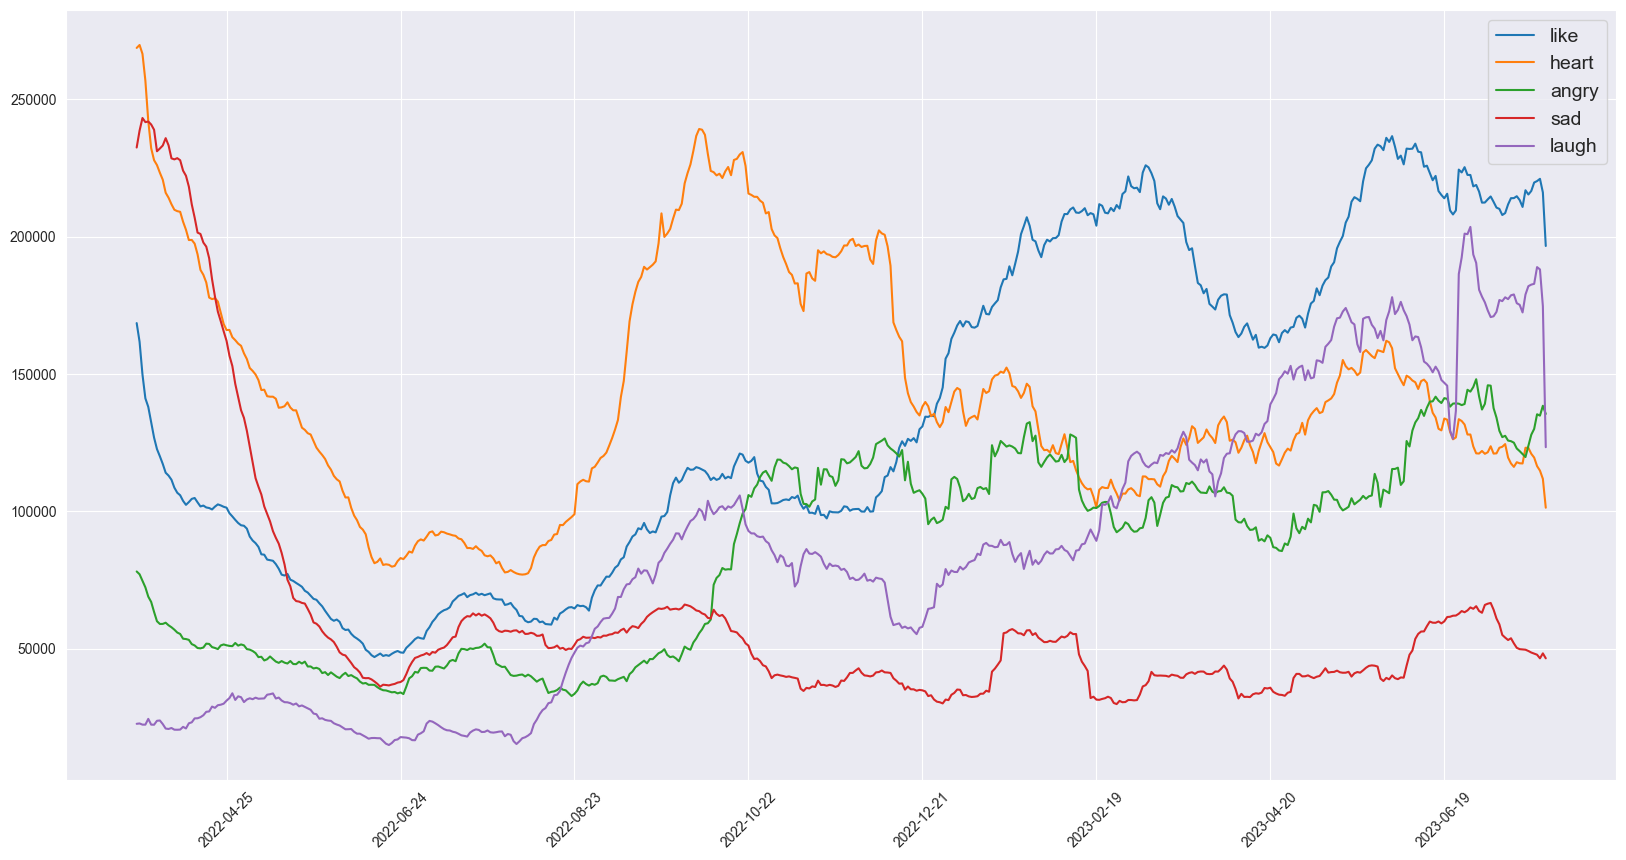

In [6]:
# import MaxNLocator to auto-select the number of x-axis ticks
from matplotlib.ticker import MaxNLocator


as_unicode = ("👍", "❤", "🤬", "😢", "😁")
emoji = ("like", "heart", "angry", "sad", "laugh")
emoji_dict = dict(zip(as_unicode, emoji))

# plot time series of most popular reactions
fig, ax = plt.subplots()

cut_df = df[df["date"] >= "2022-02-24"]  # Cut the data to only include messages from 2020-03-07

# group by days, plot curve for each reaction
for r in as_unicode:
    group = cut_df.groupby("date")[r].sum()
    group = group.rolling(30).mean()  # Smooth the data with a moving average

    ax.plot(group.index, group.values, label=emoji_dict[r])  # Plot the time series for the reaction

fig.set_size_inches(20, 10)
plt.rcParams.update({"font.size": 14})
ax.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))  # Auto-select the number of x-axis ticks
plt.xticks(rotation=45)
ax.legend()
plt.show()

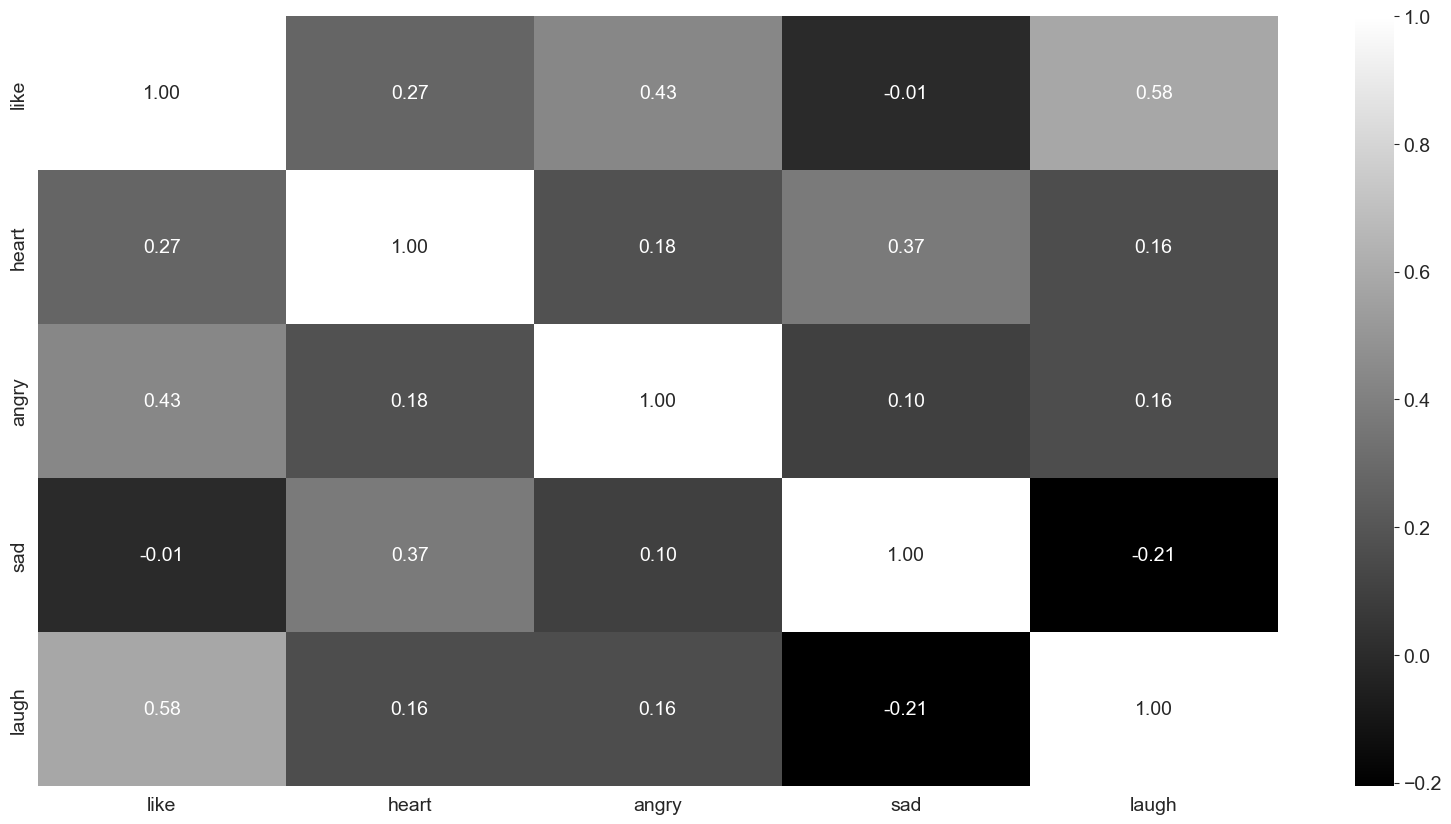

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_heatmap(cut_df, reactions):
    """
    Search for correlation between the top 10 reactions in the DataFrame.

    Parameters:
        cut_df (pandas.DataFrame): The DataFrame containing the time series data.
        reactions (list): List of column names representing the reactions.

    Returns:
        None (Displays a heatmap of the correlation matrix).
    """
    # Group the DataFrame by date and sum reactions
    reactions = list(reactions)
    group = cut_df.groupby("date")[reactions].sum()

    # Create a heatmap to visualize the correlation matrix
    fig, ax = plt.subplots()
    sns.heatmap(group.corr(), annot=True, fmt=".2f", cmap="gray", ax=ax)
    fig.set_size_inches(20, 10)
    plt.rcParams.update({"font.size": 14})
    plt.show()
    
# rename columns from emoji to word
cut_df = cut_df.rename(columns=emoji_dict)
correlation_heatmap(cut_df, emoji)

In [8]:
correlation = cut_df.groupby("date")[list(emoji)].sum().corr()
print(f"Average correlation between reactions: {correlation.mean().mean()}")

Average correlation between reactions: 0.36322886445585306


In [9]:
big_text = " ".join(cut_df["text"].tolist())
print(f"Total number of characters: {humanize.intcomma(len(big_text))}")

Total number of characters: 24,466,646


In [11]:
words, rest = split_by_words_and_rest(big_text)
unique_words = unique(words)
unique_rest = unique("".join(rest))

print(f"Total number of words: {humanize.intcomma(len(words))}")
print(f"Total number of unique words: {humanize.intcomma(len(unique_words))}")
print(f"Total number of characters in rest: {humanize.intcomma(len(rest))}")
print(f"Total number of unique characters in rest: {humanize.intcomma(len(unique_rest))}")

using form: [\w’'‘`]+
Total number of words: 3,335,567
Total number of unique words: 149,232
Total number of characters in rest: 3,335,567
Total number of unique characters in rest: 752


In [12]:
word_keys = list(unique_words.keys())
for i in range(500):
    print(f"{i + 1}. {word_keys[i]}: {unique_words[word_keys[i]]}")

1. на: 67090
2. та: 57276
3. у: 54068
4. в: 52124
5. з: 43385
6. і: 32196
7. не: 26731
8. що: 26134
9. до: 25104
10. за: 24472
11. про: 19409
12. україни: 17754
13. це: 17382
14. для: 16415
15. по: 12050
16. від: 11222
17. а: 10953
18. of: 10046
19. україні: 9574
20. ukraine: 9460
21. times: 9186
22. які: 9005
23. ми: 8973
24. також: 8533
25. під: 8446
26. із: 8301
27. рф: 8253
28. ще: 8209
29. як: 7715
30. росії: 7058
31. вже: 6980
32. він: 6515
33. є: 6463
34. зсу: 6412
35. області: 6189
36. але: 5811
37. 2: 5728
38. через: 5535
39. вони: 5446
40. його: 5438
41. час: 5414
42. окупанти: 5396
43. росіяни: 5384
44. людей: 5363
45. тривога: 5272
46. сьогодні: 5208
47. щоб: 5112
48. україна: 4940
49. 1: 4778
50. буде: 4666
51. оборони: 4614
52. після: 4555
53. війни: 4501
54. the: 4469
55. й: 4402
56. проти: 4357
57. так: 4334
58. російські: 4146
59. який: 4138
60. напрямку: 4066
61. ворог: 4062
62. території: 4054
63. російських: 4044
64. 5: 4019
65. сша: 3956
66. 3: 3935
67. було: 3810


In [13]:
rest_keys = list(unique_rest.keys())
for i in range(100):
    print(f"{i + 1}. '{rest_keys[i]}': {unique_rest[rest_keys[i]]}")

1. ' ': 3339998
2. '
': 289517
3. '.': 247004
4. ',': 223882
5. '-': 54874
6. '️': 50566
7. '▪': 27028
8. ':': 27024
9. '"': 26281
10. '«': 26043
11. '»': 25954
12. '–': 22633
13. '!': 21852
14. '—': 14012
15. '/': 11616
16. '⚡': 9290
17. ')': 8921
18. '(': 8763
19. '❗': 6479
20. '‼': 5505
21. ' ': 3906
22. '•': 3752
23. '+': 3747
24. '?': 3645
25. ';': 3366
26. '%': 3170
27. '🇺': 2619
28. '🇦': 2343
29. '“': 2338
30. '‒': 2332
31. '#': 2297
32. '”': 2277
33. '​': 2032
34. '$': 1677
35. '👊': 1554
36. '№': 1487
37. '📍': 1407
38. '🔥': 1315
39. '🤬': 1139
40. '~': 934
41. '✊': 870
42. '💛': 821
43. '💙': 795
44. '…': 793
45. '✍': 784
46. '🏻': 708
47. '€': 687
48. '@': 656
49. '👀': 648
50. '💪': 616
51. '🤡': 578
52. '😉': 494
53. '❤': 459
54. '✅': 454
55. '🇪': 444
56. '👇': 435
57. '▫': 425
58. '🇱': 323
59. '🇸': 301
60. '💬': 268
61. '🇹': 257
62. '🔺': 252
63. '🤝': 250
64. '🤔': 237
65. '🇵': 236
66. '⏺': 235
67. '‍': 234
68. '❌': 227
69. '🇬': 225
70. '🎉': 221
71. '👉': 219
72. '🇷': 218
73. '*': 216
7

<Axes: ylabel='count'>

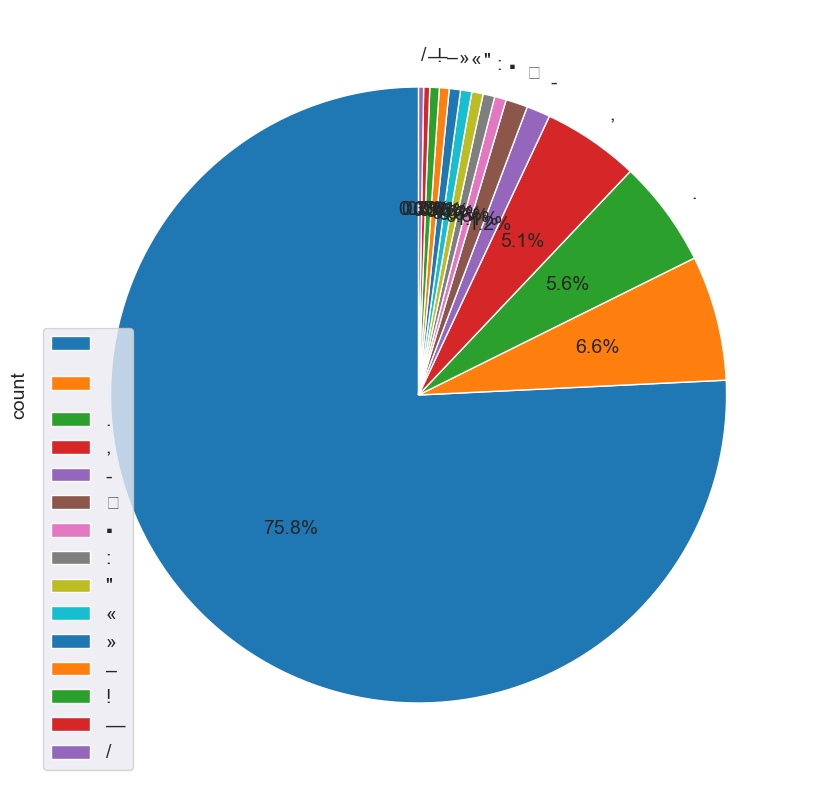

In [14]:
# plot pie chart of rest characters
rest = pd.DataFrame(unique_rest.items(), columns=["character", "count"])
rest = rest.sort_values(by="count", ascending=False)
rest_small = rest[rest["count"] < 10_000]
rest = rest[rest["count"] >= 10_000]
# rest += rest_small.sum()
rest = rest.set_index("character")
rest.plot.pie(y="count", figsize=(10, 10), autopct='%1.1f%%', startangle=90)

In [15]:
# save rest where count >= 10_000 to csv
rest_path = "../data/rest.csv"
rest.to_csv(rest_path)
print(f"Saved rest to {rest_path}")

Saved rest to ../data/rest.csv


In [14]:
def find_similar_words(word, word_counts, threshold=0.8):
    """
    Find similar words by root.
    :param word: 
    :param word_counts: 
    :param threshold: 
    :return: 
    """
    similar_words = []
    
    for w in word_counts.keys():
        if w == word:
            continue
        
        if word_similarity_fuzzy(word, w) > threshold:
            similar_words.append(w)
            
    return similar_words

similar_words = find_similar_words("україна", unique_words, 0.9)
print(f"Found {len(similar_words)} similar words and their count: {[(w, unique_words[w]) for w in similar_words]}")

Found 3 similar words and their count: [('країна', 705), ('українка', 58), ('україн', 2)]


In [15]:
left, right = 0.75, 0.8
word = "україна"
similar_left = find_similar_words(word, unique_words, left)
similar_right = find_similar_words(word, unique_words, right)
print(f"Found {len(similar_left)} similar words for left: {similar_left}")
print(f"Found {len(similar_right)} similar words for right: {similar_right}")
# find not similar words for both
not_similar = [w for w in similar_left if w not in similar_right]
print(f"Found {len(not_similar)} not similar words and their count: {[(w, unique_words[w]) for w in not_similar]}")

Found 40 similar words for left: ['україни', 'україні', 'україну', 'країни', 'країн', 'українці', 'україною', 'українська', 'країні', 'країна', 'країну', 'країнах', 'україно', 'країнами', 'країнам', 'українця', 'українка', 'українок', 'українки', 'украина', 'українцю', 'красна', 'українкам', 'українку', 'екрана', 'кранах', 'країно', 'україн', 'украіна', 'ураїни', 'українофоба', 'україножера', 'украинца', 'украні', 'українства', 'окраїнах', 'україниз', 'каїна', 'радукраїна', 'крана']
Found 18 similar words for right: ['україни', 'україні', 'україну', 'країн', 'українська', 'країна', 'країнах', 'україно', 'країнам', 'українка', 'украина', 'українкам', 'україн', 'украіна', 'українства', 'каїна', 'радукраїна', 'крана']
Found 22 not similar words and their count: [('країни', 2781), ('українці', 1194), ('україною', 927), ('країні', 750), ('країну', 466), ('країнами', 218), ('українця', 95), ('українок', 49), ('українки', 47), ('українцю', 22), ('красна', 16), ('українку', 9), ('екрана', 6), 

In [42]:
# find text with "українцяз"
ukraincyaz = df[df["text"].str.contains(" м ")]
ukraincyaz

,id,source,date,time,text,views,forwards,containing_media,👍,❤,🤬,😢,😁
129,19020,Times of Ukraine,2023-07-19,18:31:09,💛 Ексклюзив. Журналісти Times of Ukraine розшу...,183645,110,True,730.0,2030.0,527.0,15.0,NaN
185,18945,Times of Ukraine,2023-07-17,21:18:42,Ціна на газ для українців залишиться без змін ...,216060,325,True,846.0,1892.0,29.0,15.0,NaN
228,18886,Times of Ukraine,2023-07-16,14:00:11,«Вам просто треба об'їхати мінне поле»: як у Н...,193715,511,True,250.0,42.0,3878.0,138.0,NaN
614,18419,Times of Ukraine,2023-07-03,09:27:53,💛 Молодший син мера Києва Віталія Кличка 18-рі...,219719,1313,True,5056.0,1.0,172.0,NaN,28.0
1001,18006,Times of Ukraine,2023-06-23,09:22:03,Стиснуло як бляшанку. Драматачний фінал у істо...,165643,984,True,292.0,NaN,NaN,4083.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73379,4067,Ukraine NOW,2022-03-06,15:50:01,Вінницький аеропорт: внаслідок ракетного обстр...,495563,694,True,NaN,95.0,NaN,4700.0,NaN
73784,3609,Ukraine NOW,2022-03-03,09:52:09,Чернігівська область↘️\n\n3 березня близько 08...,452198,563,True,NaN,41.0,NaN,3019.0,NaN
74524,2765,Ukraine NOW,2022-02-26,11:11:14,Київ↘️\n\nО 10:18 пожежу в складських будівлях...,425113,547,True,388.0,98.0,NaN,1860.0,NaN
74668,2609,Ukraine NOW,2022-02-24,21:02:04,⚡️ДНСНС повідомляє: \n\n❗️Ситуація щодо росій...,481426,1063,False,4899.0,1374.0,NaN,370.0,NaN


In [17]:
# print count of крана in unique words
print(f"Count of 'крана': {unique_words['cтаном']}")

Count of 'крана': 1


In [18]:
part = 0.9
words_count = 0
unique_words_count = 0
for w in list(unique_words.keys()):
    words_count += unique_words[w]
    unique_words_count += 1
    if words_count / len(words) > part:
        print(f"Top {int(part * 100)}% of words: {unique_words_count}, {words_count} words")
        break

Top 90% of words: 20446, 3002021 words


In [19]:
# save unique words to csv
unique_words_path = "../data/unique_words.csv"
with open(unique_words_path, "w", encoding="UTF-8") as f:
    f.write("word,count\n")
    for w in unique_words.keys():
        f.write(f"{w},{unique_words[w]}\n")
        
print(f"Saved unique words to {unique_words_path}")

Saved unique words to ../data/unique_words.csv


In [32]:
def words_similarity(word, words):
    similar_words = {}
    for w in words.keys():
        similar_words[w] = word_similarity_fuzzy(word, w)
        
    return similar_words

unique_words_optimized = unique_words.copy()
trashholds = {
    0.0: 3,
    0.5: 10,
    0.6: 50,
    0.7: 100,
    0.8: 500,
    0.9: 1000,
}
remove_words = []
i = 0
while True:
    word = list(unique_words_optimized.keys())[i]
    
    similar_words = words_similarity(word, unique_words_optimized)
    for w in similar_words.keys():
        for t in trashholds.keys():
            if unique_words[w] <= trashholds[t]:
                if similar_words[w] > t:
                    remove_words.append(w)
                    # unique_words_optimized[word] += unique_words_optimized[w]
                    unique_words_optimized.pop(w)
                break
        
    percent = sum(unique_words_optimized.values()) / sum(unique_words.values()) * 100
    print(f"{i + 1}. new dict size: {len(unique_words_optimized)}, removed words: {len(remove_words)}, percent: {percent:.2f}%")
    
    if percent <= 90:
        break
    
    i += 1


1. new dict size: 80632, removed words: 68600, percent: 97.01%
2. new dict size: 72720, removed words: 76512, percent: 96.63%
3. new dict size: 69055, removed words: 80177, percent: 96.47%
4. new dict size: 65406, removed words: 83826, percent: 96.31%
5. new dict size: 64772, removed words: 84460, percent: 96.28%
6. new dict size: 63163, removed words: 86069, percent: 96.20%
7. new dict size: 61972, removed words: 87260, percent: 96.14%
8. new dict size: 60798, removed words: 88434, percent: 96.09%
9. new dict size: 60641, removed words: 88591, percent: 96.06%
10. new dict size: 60572, removed words: 88660, percent: 96.04%
11. new dict size: 60045, removed words: 89187, percent: 95.95%
12. new dict size: 59553, removed words: 89679, percent: 95.84%
13. new dict size: 59524, removed words: 89708, percent: 95.84%
14. new dict size: 59450, removed words: 89782, percent: 95.82%
15. new dict size: 59392, removed words: 89840, percent: 95.80%
16. new dict size: 59222, removed words: 90010, p

In [34]:
# check if words contain numbers
import re

def has_numbers(word):
    return bool(re.search(r"\d", word))

with_number = {}
for w in unique_words_optimized.keys():
    if has_numbers(w):
        with_number[w] = unique_words_optimized[w]
        
# sort by count
with_number = dict(sorted(with_number.items(), key=lambda item: item[1], reverse=True))
with_number

{'2': 5728,
 '1': 4778,
 '5': 4019,
 '3': 3935,
 '10': 3415,
 '4': 3256,
 '6': 2568,
 '00': 2296,
 '7': 2129,
 '8': 2112,
 '24': 2106,
 '20': 2104,
 '30': 2088,
 '15': 2017,
 '2022': 1989,
 '12': 1898,
 '9': 1838,
 '16': 1698,
 '18': 1575,
 '11': 1560,
 '000': 1427,
 '14': 1372,
 '100': 1369,
 '22': 1341,
 '13': 1302,
 '25': 1237,
 '17': 1214,
 '50': 1135,
 '23': 1132,
 '300': 1065,
 '19': 1033,
 '40': 995,
 '2023': 979,
 '21': 960,
 '500': 794,
 '02': 748,
 '60': 732,
 '200': 721,
 '28': 673,
 '35': 662,
 '27': 628,
 '29': 609,
 '26': 559,
 '2014': 545,
 '80': 536,
 '70': 507,
 '31': 497,
 '90': 490,
 '400': 485,
 '06': 480,
 '52': 440,
 '45': 412,
 '03': 375,
 '36': 357,
 '136': 349,
 '72': 342,
 '34': 333,
 '600': 326,
 '32': 322,
 '150': 322,
 '155': 318,
 '55': 295,
 '38': 294,
 '05': 293,
 '120': 284,
 '37': 272,
 '42': 272,
 '07': 267,
 '59': 266,
 '0': 265,
 '1000': 259,
 '04': 253,
 '800': 252,
 '93': 246,
 '2021': 245,
 '33': 244,
 '68': 242,
 '250': 239,
 '54': 239,
 '31к': 

In [35]:
len(with_number)

1009

In [36]:
# remove words with numbers
for w in with_number.keys():
    unique_words_optimized.pop(w)
    
print(f"New dict size: {len(unique_words_optimized)}")

New dict size: 32237


In [37]:
# save optimized unique words to csv
unique_words_optimized_path = "../data/unique_words_optimized.csv"
with open(unique_words_optimized_path, "w", encoding="UTF-8") as f:
    f.write("word,count\n")
    for w in unique_words_optimized.keys():
        f.write(f"{w},{unique_words_optimized[w]}\n")
        
print(f"Saved unique words to {unique_words_optimized_path}")

Saved unique words to ../data/unique_words_optimized.csv


In [40]:
# find similar words for "україна"
similar_words = find_similar_words("україна", unique_words_optimized, 0.8)
print(f"Found {len(similar_words)} similar words and their count: {[(w, unique_words_optimized[w]) for w in similar_words]}")

Found 5 similar words and their count: [('україни', 17754), ('україні', 9574), ('україну', 3564), ('країн', 1453), ('українська', 835)]
